# Introduction

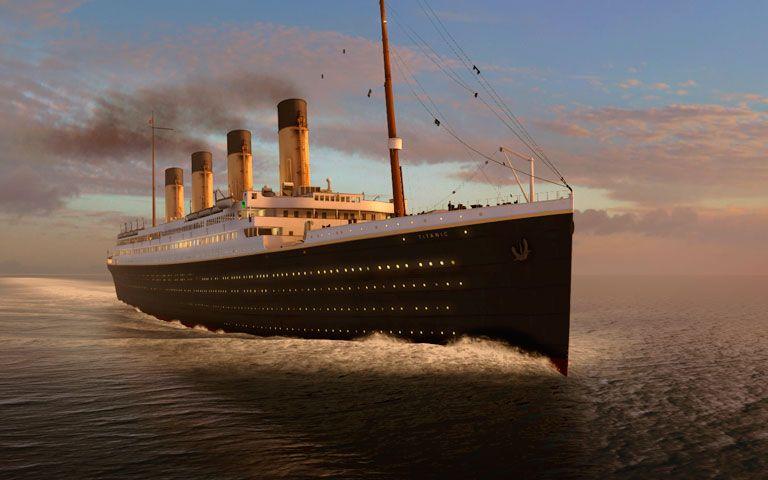

**"It Was The Ship Of Dreams."**

This was one of the famous dialog from the Titanic movie, and it was so true.

RMS Titanic was a British passenger liner, the largest ship afloat at the time she entered service. Titanic sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, UK, to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, which made the sinking possibly one of the deadliest for a single ship up to that time.
I always used to wonder whether it's possible to save as many as possible people from the ship. We didn't get a chance to save them, but fortunately, this dataset provide us the opportunity to predict it :) 

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing    
le = preprocessing.LabelEncoder()

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline 

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

#Instantiate CatBoostClassifier
cbc = CatBoostClassifier()

In [ ]:
titanic_train_df = pd.read_csv('../input/titanic/train.csv')
titanic_test_df  = pd.read_csv('../input/titanic/test.csv')

In [ ]:
titanic_train_df.head()

In [ ]:
titanic_train_df.describe()

In [ ]:
titanic_train_df.info()

In [ ]:
n = titanic_train_df.nunique(axis=0)  
print("No.of.unique values in each column :\n", n)

In [ ]:
titanic_train_df.shape

# Exploratory Data Analysis(EDA)

In [ ]:
plt.figure(figsize=(10,10))
g=sns.heatmap(titanic_train_df.corr(),annot=True,cmap="YlGnBu")

In [ ]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=titanic_train_df)

In [ ]:
sns.histplot(data=titanic_train_df, x="SibSp", binwidth=1,hue="Survived", multiple="stack", kde=True)

In [ ]:
g = sns.catplot(x="Fare", y="Survived", row="Pclass", kind="box", orient="h", height=1.5, aspect=4,
                data=titanic_train_df.query("Fare > 0"))
g.set(xscale="log")

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
sns.boxplot(x='Survived', y='Fare', data=titanic_train_df)

In [ ]:
sns.scatterplot(data=titanic_train_df, x='Age', y='Fare',hue="Survived",
                size='Sex', sizes=(20, 60), legend="full")

In [ ]:
sns.histplot(data=titanic_train_df, x="Age", binwidth=5,hue="Survived", multiple="stack", kde=True)

Lets start with **Title** column, as we see there are multiple Title, which may depict same values, so its better we do text correct. Ex. Ms and Miss both are same. Mme actual meaning is Mrs. Other values may not help us in algorithm, its better we convert these values to one value. I have used 'Other'

# Feature Engineering

We have 3 entries with Ticket fare more than 500, as we dont have lot of rows. We can handle this outlier rather than removing it. I have taken mean of Fare, and assigned it to outlier

In [ ]:
titanic_train_df.loc[titanic_train_df['Fare'] > 500, 'Fare'] = titanic_train_df['Fare'].mean()

In [ ]:
def findtitle(line):   
    splitLine = line.split(',')
    name = splitLine[1].split('.')
    title = name[0].strip()
    return title

In [ ]:
titanic_train_df['Title'] = titanic_train_df['Name'].apply(findtitle)
titanic_test_df['Title'] = titanic_test_df['Name'].apply(findtitle)

In [ ]:
titanic_train_df['Title'].unique()

In [ ]:
titanic_train_df['Title'] = titanic_train_df['Title'].replace(to_replace =["Lady", "Countess","Capt", "Col","Don", "Dr", "Major", "Rev", "Sir", "Jonkheer","Dona","the Countess"], value ="Other")
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Mlle', 'Miss')
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Ms', 'Miss')
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Mme', 'Mrs')


In [ ]:
sns.histplot(data=titanic_train_df, x="Title", binwidth=1,hue="Survived", multiple="stack", kde=True)

In [ ]:
titanic_train_df['Title'] = le.fit_transform(titanic_train_df['Title'])

In [ ]:
titanic_test_df['Title'] = titanic_test_df['Title'].replace(to_replace =["Lady", "Countess","Capt", "Col","Don", "Dr", "Major", "Rev", "Sir", "Jonkheer","Dona","the Countess"], value ="Other")
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Mlle', 'Miss')
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Ms', 'Miss')
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Mme', 'Mrs')

titanic_test_df['Title'] = le.fit_transform(titanic_test_df['Title'])

In [ ]:
def getTicketDetail(ticket):
    split_data = ticket.split(" ")
    if len(split_data) > 1:
        return split_data[0]
    else:
        return "Other"

In [ ]:
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].apply(getTicketDetail)
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].apply(getTicketDetail)

In [ ]:
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace(".","")
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("/","")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace(".","")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("/","")

In [ ]:
titanic_train_df['Ticket'].unique()

In [ ]:
titanic_train_df['Ticket'] = le.fit_transform(titanic_train_df['Ticket'])
titanic_test_df['Ticket'] = le.fit_transform(titanic_test_df['Ticket'])

In [ ]:
def missing_percent_of_column(train_set):
    nan_percent = 100*(train_set.isnull().sum()/len(train_set))
    nan_percent = nan_percent[nan_percent>0].sort_values(ascending=False).round(1)
    DataFrame = pd.DataFrame(nan_percent)
    # Rename the columns
    mis_percent_table = DataFrame.rename(columns = {0 : '% of Misiing Values'}) 
    # Sort the table by percentage of missing descending
    mis_percent = mis_percent_table
    return mis_percent

In [ ]:
miss = missing_percent_of_column(titanic_train_df)
miss

As most of the values for **Cabin** are not present, we can drop that column.

**Age** is one of the important columns, so even if almost 20% values do not exist, still we can not drop that column.

**PassengerId, Name** columns won't help in deciding whether a person has survived or not, so we can drop these columns.

In [ ]:
titanic_train_df = titanic_train_df.drop(['PassengerId','Cabin','Name'], axis=1)
titanic_test_df = titanic_test_df.drop(['Cabin','Name'], axis=1)

In [ ]:
titanic_train_df.Fare = titanic_train_df.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].apply(lambda x: x.fillna(x.mean()))
titanic_test_df.Fare = titanic_test_df.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
titanic_train_df['Fare'] = titanic_train_df['Fare'].round(0).astype(int)
titanic_test_df['Fare'] = titanic_test_df['Fare'].round(0)

In [ ]:
titanic_train_df['Embarked'].fillna('S', inplace = True)
titanic_test_df['Embarked'].fillna('S', inplace = True)
Embark =  {'S': 1, 'C': 2, 'Q': 3}
titanic_train_df['Embarked'] = titanic_train_df['Embarked'].map(Embark )
titanic_test_df['Embarked'] = titanic_test_df['Embarked'].map(Embark)

In [ ]:
sex_mapping = {"male": 1, "female": 2}
titanic_train_df['Sex'] = titanic_train_df['Sex'].map(sex_mapping)
titanic_test_df['Sex'] = titanic_test_df['Sex'].map(sex_mapping)

In [ ]:
titanic_train_df['TotFam'] = titanic_train_df['SibSp'] + titanic_train_df['Parch'] + 1
titanic_test_df['TotFam'] = titanic_test_df['SibSp'] + titanic_test_df['Parch'] + 1

In [ ]:
titanic_train_df = titanic_train_df.drop(['SibSp','Parch'], axis=1)
titanic_test_df = titanic_test_df.drop(['SibSp','Parch'], axis=1)

In [ ]:
titanic_train_df.Age = titanic_train_df.groupby(['Title'])['Age'].apply(lambda x: x.fillna(x.mean()))
titanic_test_df.Age = titanic_test_df.groupby(['Title'])['Age'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
#titanic_train_df = titanic_train_df.drop(['Ticket'], axis=1)
#titanic_test_df = titanic_test_df.drop(['Ticket'], axis=1)

In [ ]:
X_train = titanic_train_df.drop("Survived", axis=1)
Y_train = titanic_train_df["Survived"]
X_test  = titanic_test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

The MinMaxscaler is a type of scaler that transform features by scaling each feature the minimum and maximum values to be 0 and 1 respectively.

You can review more details on below link,

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [ ]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = norm.transform(X_train)

# transform testing dataabs
X_test = norm.transform(X_test)

In [ ]:
X_train

# Model Training & Prediction

We will be using CatBoost alogrithm. As this is ensemble learning boosting algorithm, its performance is largly depend on hyperparameter tuning.
Lets first do the HyperParaMeter tuning with the help of GridSearchCV.

In [ ]:
#create the grid
grid = {'max_depth': [3,4,5,6],
        'n_estimators':[100, 200, 300],
        'learning_rate': [0.05,0.1, 0.2,0.3,0.4,0.5],
        'l2_leaf_reg': [1, 3, 5]}

#Instantiate GridSearchCV
gscv = GridSearchCV (estimator = cbc, param_grid = grid, scoring ='accuracy', cv = 5)

#fit the model
gscv.fit(X_train, Y_train)

#returns the estimator with the best performance
#print(gscv.best_estimator_)

#returns the best score
#print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

In [ ]:
model=CatBoostClassifier(n_estimators=100, depth=3, learning_rate=0.5, loss_function='Logloss',l2_leaf_reg= 1, eval_metric='Accuracy')

# Fit model
model.fit(X_train, Y_train)

# Get predictions
y_pred = model.predict(X_test)

In [ ]:
print("Performance on train data:", model.score(X_train, Y_train))

In [ ]:
#Create a  DataFrame with the passengers ids and our prediction
submission = pd.DataFrame({'PassengerId':titanic_test_df['PassengerId'],'Survived':y_pred})

#Visualize the first 5 rows
submission.head()

In [ ]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'TitanicPredictions.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)